<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter03/Steps_to_build_a_neural_network_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
data_folder = './' # This can be any directory you want to 

# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
        
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    
    def __len__(self): 
        return len(self.x)

In [3]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [4]:
from torch.optim import SGD

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    
    return model, loss_fn, optimizer

In [5]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    opt.step()
    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    return batch_loss.item()

In [11]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    print(y, argmaxes)
    return is_correct.cpu().numpy().tolist()

In [12]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [13]:
losses, accuracies = [], []
for epoch in range(10):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
tensor([4, 9, 3, 8, 9, 0, 1, 9, 5, 7, 3, 8, 1, 5, 6, 5, 5, 1, 2, 8, 7, 5, 3, 0,
        8, 7, 0, 3, 0, 0, 4, 5], device='cuda:0') tensor([6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
tensor([6, 9, 2, 0, 5, 7, 4, 0, 3, 9, 4, 0, 0, 6, 6, 8, 4, 7, 6, 7, 1, 3, 0, 6,
        1, 1, 2, 5, 1, 0, 9, 2], device='cuda:0') tensor([6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')
tensor([2, 8, 0, 1, 9, 9, 9, 3, 0, 0, 1, 3, 0, 4, 0, 7, 7, 5, 2, 3, 3, 3, 0, 4,
        2, 4, 5, 8, 9, 7, 9, 5], device='cuda:0') tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 5, 6, 6, 6, 8, 6], device='cuda:0')
tensor([0, 3, 4, 8, 7, 6, 8, 9, 1, 9, 7, 1, 9, 0, 0, 3, 8, 3, 8, 0, 0, 9, 4, 7,
        3, 0, 4, 7, 1, 8, 3, 4], device='cuda:0') tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        

KeyboardInterrupt: 

/tmp/ipykernel_1820346/888880228.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


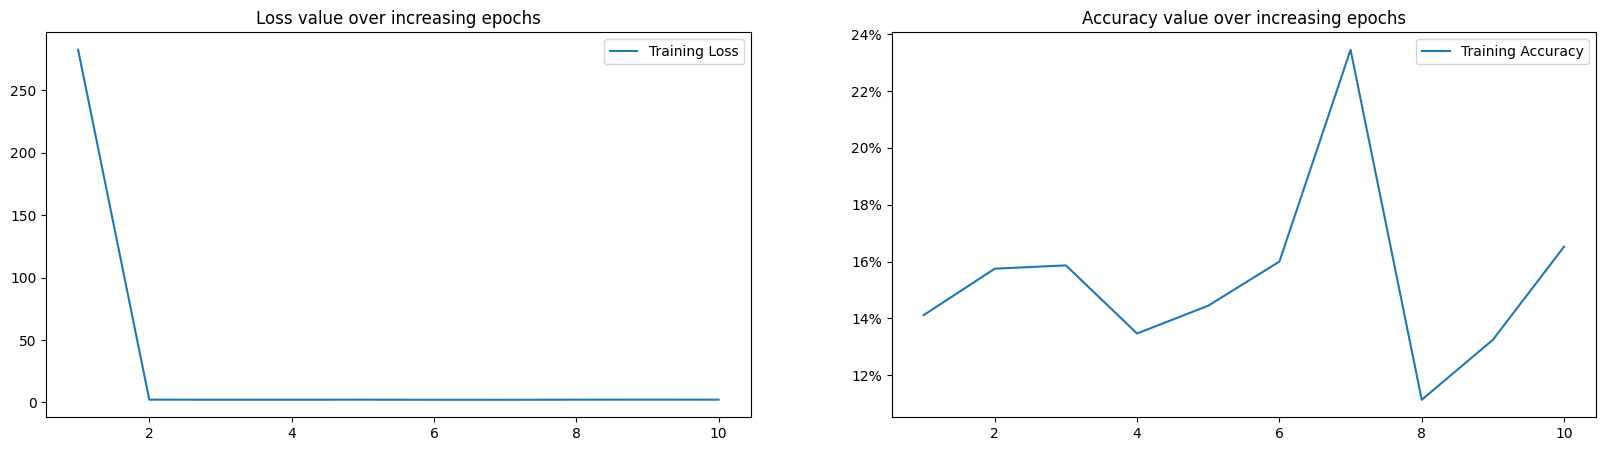

In [10]:
epochs = np.arange(10)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()